<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Tutorial 1: MovingPandas</h2>
<h3>IT University of Copenhagen, Spring 2023</h3>
</div>

This is a tutorial introducing the python library MovingPandas, which is excellent for working with trajectory data.

This notebook is based on the notebooks in [MovingPandas Examples](https://github.com/anitagraser/movingpandas-examples).

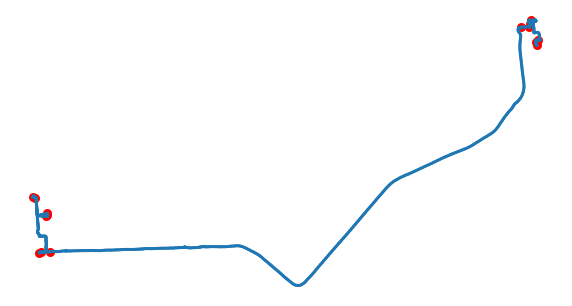

In [17]:
from IPython import display
display.Image('images/mv_illu2.png')

## What is MovingPandas? And why should you use it?

*"MovingPandas is a Python library for handling movement data based on Pandas, GeoPandas, and HoloViz.
MovingPandas provides trajectory data structures and functions for movement data exploration and analysis."*

MovingPandas is developed to work with **movement data**, more specifially ***trajectories***.

The library is based on a **Trajectory class** with associated methods.

From our exercise using **Scikit Mobility**, you might remember that trajectory data (contrary to flow data) not only includes the start/origin and end/destination locations, but also the path between the points (represented as points describing the location between the start and end points.)


**MovingPandas can for example be used for:**
- plotting trajectories
- stop detection, 
- trajectory smooting/generalisation
- aggregating large numbers of trajectories


It is built as an extension to GeoPandas and thus integrates nicely with the other workflows we have been using in this course.

See an overview of other tools for working with movement data [here](https://github.com/anitagraser/movement-analysis-tools).

MovingPandas is maintained by [Anita Graser](https://anitagraser.com/).
## Working with MovingPandas 

### Useful links

- [Introduction](https://github.com/movingpandas/movingpandas)
- [Documentation](https://movingpandas.readthedocs.io/en/main/)
- [Tutorials](https://github.com/movingpandas/movingpandas/tree/main/tutorials)
- [Examples](https://github.com/movingpandas/movingpandas-examples)

### Installing MovingPandas

To install MovingPandas with all it's dependencies, simply run:

`conda install -c conda-forge movingpandas`

To create an environment just for this tutorial (and avoid having to mess with your docker installation):

1. Navigate to your folder with the tutorial materials
2. Run `conda env create -f mvp_environment.yml`
### Tutorial Data

The tutorial was downloaded from the MovingPandas [example repository](https://github.com/anitagraser/movingpandas-examples/tree/main/data), where you also can find more examples of trajectory data.
### The Basics

Below you have examples of some of the basic functionalities for working with trajectory data.

In [18]:
# import libraries
import movingpandas as mpd
import geopandas as gpd
from datetime import datetime, timedelta
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':3, 'capstyle':'round', 'figsize':(15,15), 'legend':True}


#### Loading Trajectory Data to MovingPandas

**A Trajectory object consist of 2 core elements:**
- Trajectory ID that distinguishes individual objects
- A GeoDataFrame with point geometries (points in the trajectory), indexed by a DateTimeIndex

These elements thus describe:
1. *Which* object the trajectory belong to
2. The *location* of the trajectory
3. *When* the object was at each point in the trajectory

When you have a dataset with several trajectory objects, they can be loaded as a **trajectory collection**.

We will be loading the data from a GeoDataFrame, but Trajectory collections can also be loaded from a CSV or created manually.

**OBS!** It as as always important to consider the crs of your data. It might be necessary to reproject it to a projected crs, before creating your trajectories.

In [19]:
# Read the data
gdf = gpd.read_file('data/geolife_small.gpkg')

# Reproject to projected crs
crs = 'EPSG:32650'
gdf = gdf.to_crs(crs) # Our data is in Beijing, China, so we are using an UTM Zone for this area
gdf

,id,sequence,trajectory_id,tracker,t,geometry
0,1,1,1,19,2008-12-11 04:42:14+00,POINT (447965.009 4416677.210)
1,2,2,1,19,2008-12-11 04:42:16+00,POINT (447966.068 4416682.086)
2,3,3,1,19,2008-12-11 04:43:26+00,POINT (447932.811 4416681.869)
3,4,4,1,19,2008-12-11 04:43:32+00,POINT (447924.707 4416684.366)
4,5,5,1,19,2008-12-11 04:43:47+00,POINT (447803.126 4416694.964)
...,...,...,...,...,...,...
5903,6993,867,5,2,2009-02-25 14:31:04+00,POINT (443362.019 4419780.002)
5904,6994,868,5,2,2009-02-25 14:31:09+00,POINT (443363.134 4419780.549)
5905,6995,869,5,2,2009-02-25 14:31:14+00,POINT (443367.553 4419777.187)
5906,6996,870,5,2,2009-02-25 14:31:19+00,POINT (443370.197 4419776.501)


As you can see, if we plot the GeoDataFrame we just have a lot of points placed closely together:

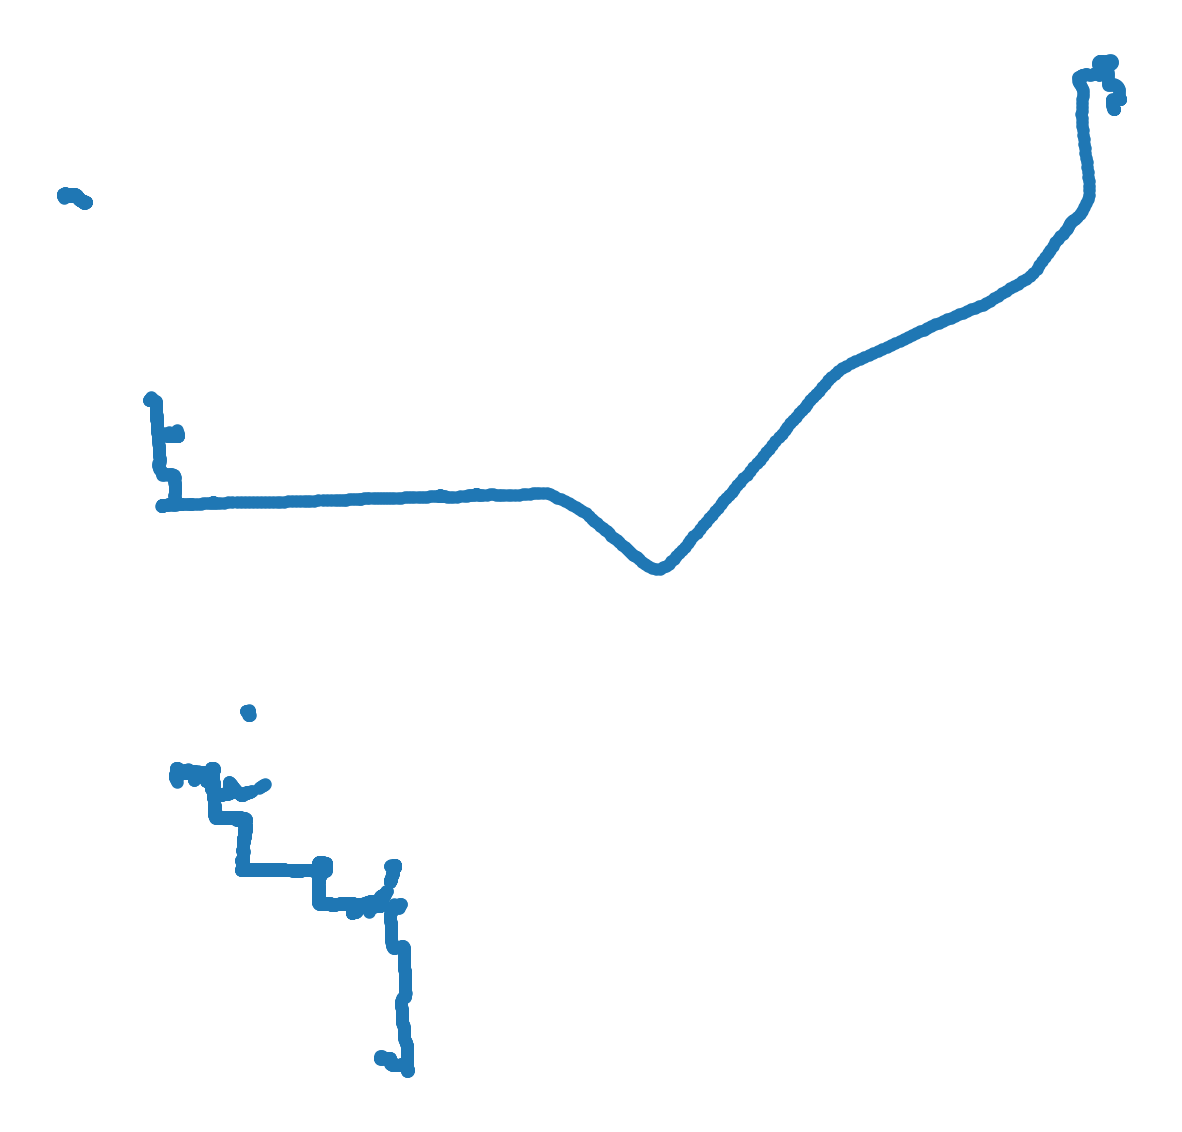

In [20]:
ax = gdf.plot(**plot_defaults)

ax.set_axis_off()

In [21]:
# Construct trajectory collection
traj_collection = mpd.TrajectoryCollection(gdf, 'trajectory_id', t='t')
traj_collection

TrajectoryCollection with 5 trajectories

MovingPandas come with built-in support for plotting.

If we plot our newly constructed trajectories, we can see that the many points have been converted into trajectories.

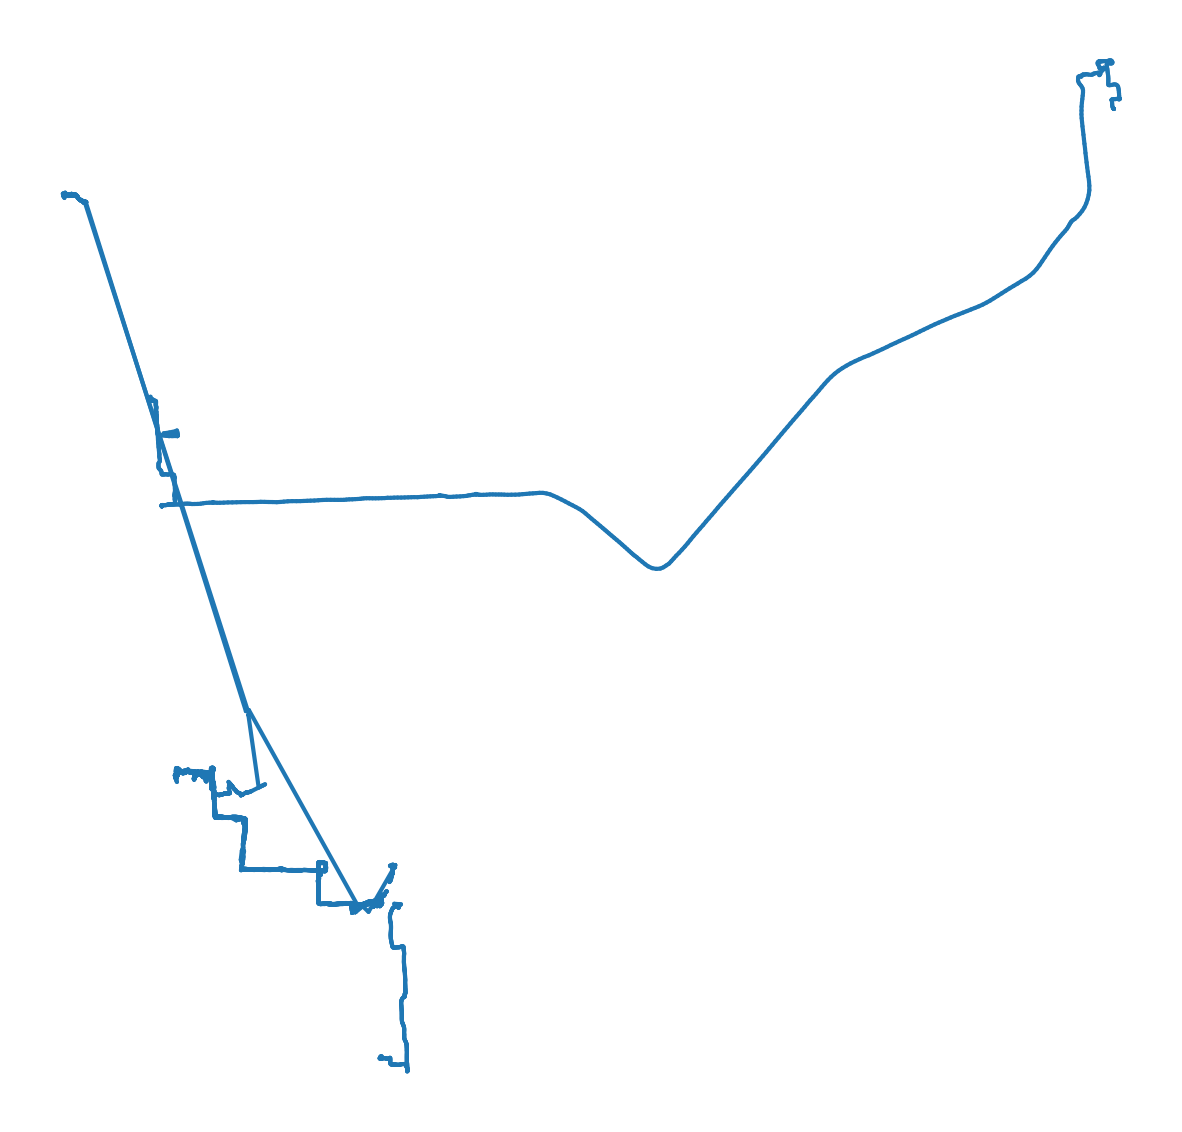

In [22]:
ax = traj_collection.plot(**plot_defaults)

ax.set_axis_off()

If you want to access a specific trajectory, this can be done by using the index of the trajectory.

In [23]:
one_traj = traj_collection.trajectories[1]
print(one_traj)

Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 897 | Length: 38750.1m
Bounds: (441894.28950375254, 4424754.778094986, 465263.4345706517, 4436996.183477079)
LINESTRING (465120.8405573368 4435824.385533892, 465116.4299642617 4435829.511549944, 465114.2231393


To access e.g. the trajectory length:

In [24]:
one_traj.get_length()

38750.11232207025

Plot individual trajectory:

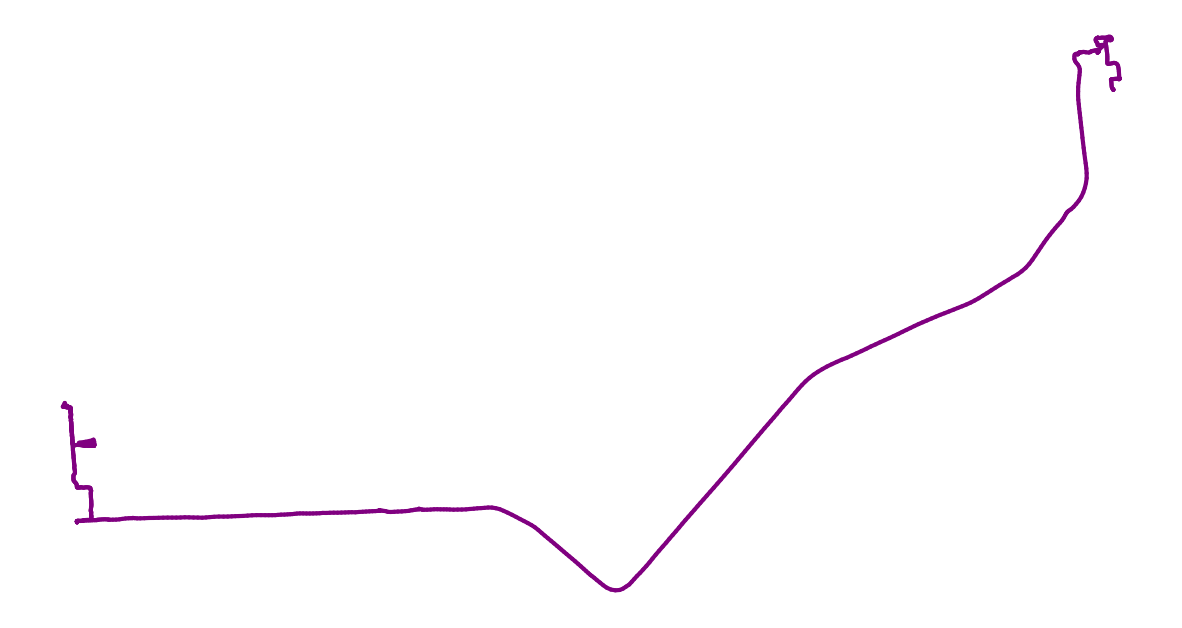

In [25]:
ax = one_traj.plot(color='purple', **plot_defaults)

ax.set_axis_off()

#### Plotting Trajectory Speed

Trajectory objects come with a built-in function for adding the travel speed:

In [26]:
help(mpd.Trajectory.add_speed)

Help on function add_speed in module movingpandas.trajectory:

add_speed(self, overwrite=False, name='speed')
    Add speed column and values to the trajectory's DataFrame.
    
    Speed is calculated as CRS units per second, except if the CRS is
    geographic (e.g. EPSG:4326 WGS84) then speed is calculated in meters
    per second.
    
    Parameters
    ----------
    overwrite : bool
        Whether to overwrite existing speed values (default: False)
    name : str
        Name of the speed column (default: "speed")



Even without explicitly calling the add_speed function, we can plot the trajectory (or the trajectory collection) by the travel speed:

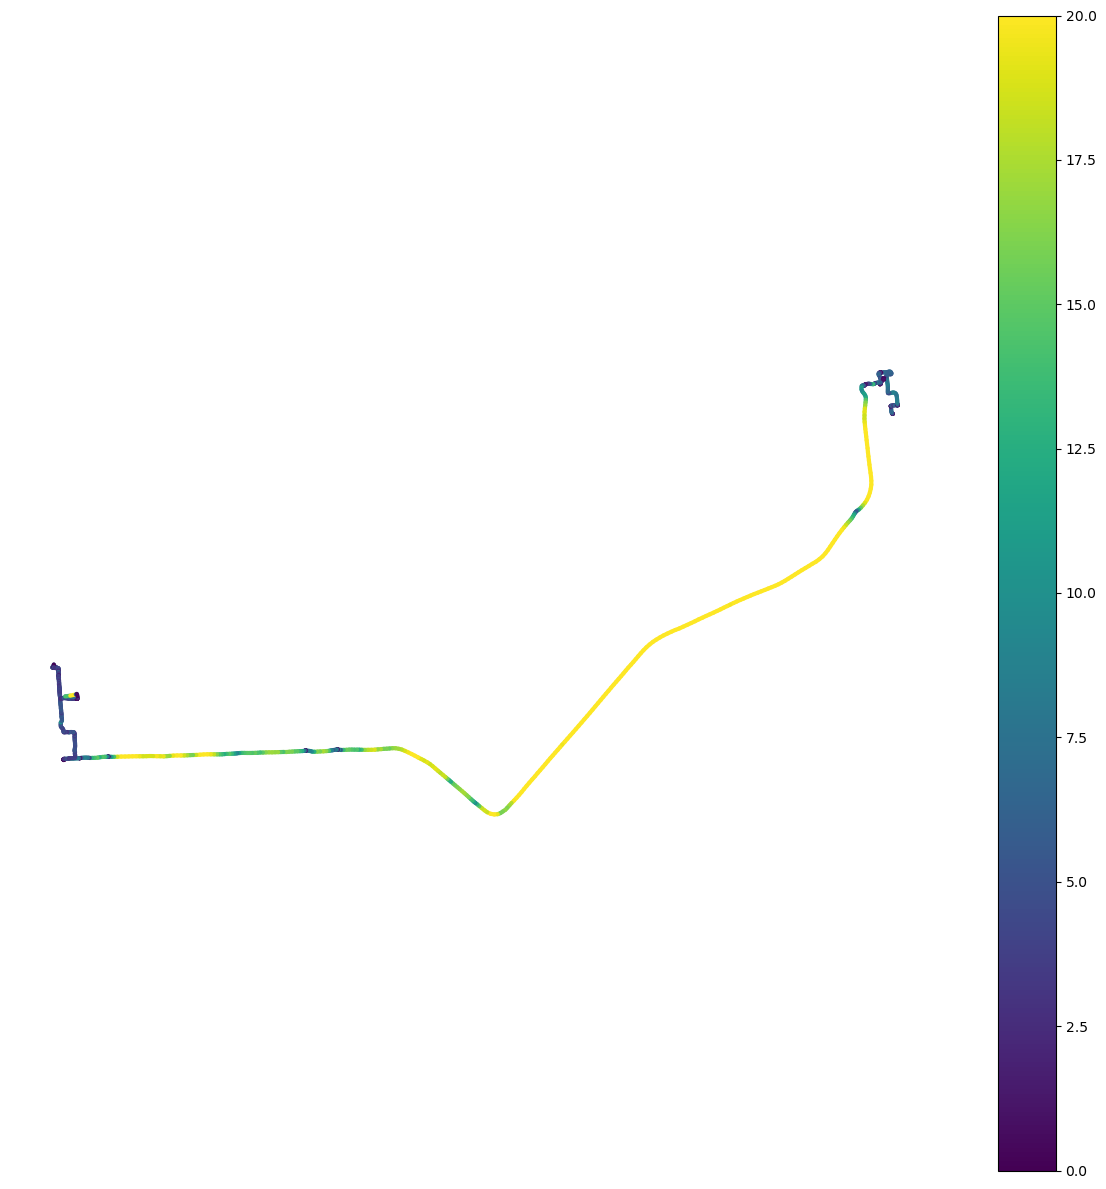

In [27]:
ax = one_traj.plot(column='speed', vmax=20, **plot_defaults)

ax.set_axis_off()

#### Get Trajectory Position/Segment

You can extract an element of a trajectory based on e.g. the position at a given time or time range, or based on the intersection with another geometry.

**Get Position Based on Time**

In [28]:
# Get location based on time. The exact time does not have to be encoded in the trajectory.

time1 = datetime(2009,6,29,7,35,0) # Not an actual time in trajectory
time2 = datetime(2009,6,29,7,2,25) # Actual time in trajectory

# Get the nearest actual point, if there is no point with this exact time. Other options are interpolate or to fill from the previous or next row
p1 = one_traj.get_position_at(time1, method="nearest") 
p2 = one_traj.get_position_at(time2, method="nearest")

print(p1)
print(p2)

POINT (464415.6451183946 4434988.985019907)
POINT (465120.8405573368 4435824.385533892)


**Extract a Trajectory Segment**

Use the method get_segment_between to get the segment of a trajectory between to times. Returns a trajectory object.

In [29]:
time1 = datetime(2009,6,29,8,5,25) 
time2 = datetime(2009,6,29,11,0,0)

segment = one_traj.get_segment_between(time1, time2)
print(segment)

Trajectory 2_2009-06-29 08:05:25 (2009-06-29 08:05:25 to 2009-06-29 10:59:57) | Size: 213 | Length: 4066.2m
Bounds: (441894.28950375254, 4426258.223116485, 442527.28309522086, 4428898.273971625)
LINESTRING (442209.7235000906 4426258.223116485, 442208.02601096034 4426259.5679753795, 442208.55767


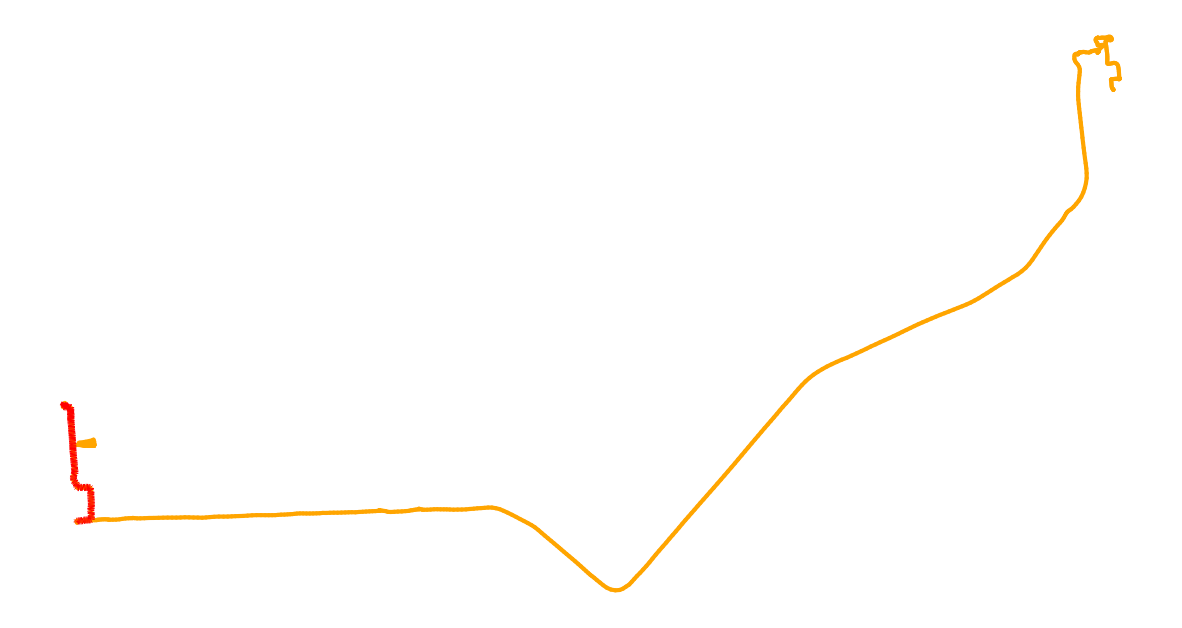

In [30]:
ax = one_traj.plot(color='orange', **plot_defaults)
segment.plot(ax=ax, color='red', linewidth=5)

ax.set_axis_off()

**Get the part of a trajectory that intersects another geometry**

This method returns a trajectory collection if more than one trajectory is created by the clipping.

In [31]:
# Createa a polygon which is a bit smaller than the trajectory
xmin, xmax, ymin, ymax = one_traj.get_bbox()

dist = 1000

poly = Polygon([(xmin+dist, ymin+dist), (xmin+dist, ymax-dist), (xmax-dist, ymax-dist), (xmax-dist, ymin+dist), (xmin+dist, ymin+dist)])

intersections = one_traj.clip(poly)
intersections

TrajectoryCollection with 2 trajectories

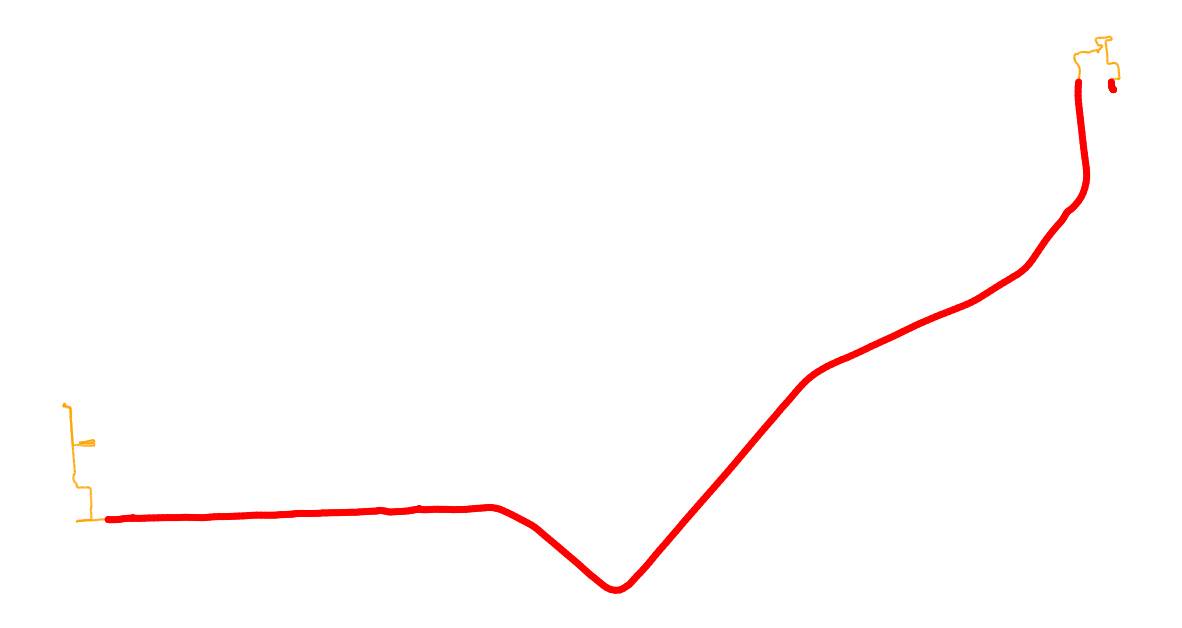

In [32]:
fig, ax = plt.subplots(figsize=(15,15))

one_traj.plot(ax=ax, color='orange')
intersections.plot(ax=ax, color='red', linewidth=5, capstyle='round')
ax.set_axis_off()

#### Split Trajectories

Trajectories can be split if there e.g. are a time gap in observations, if the object is moving at a very low speed, or if the object does not move away from the same location for a while.

**Split trajectories where there is a time gap in observations:**

In [33]:
split = mpd.ObservationGapSplitter(one_traj).split(gap=timedelta(minutes=5))
split

TrajectoryCollection with 3 trajectories

In [34]:
# See results
split.to_traj_gdf()

,traj_id,start_t,end_t,geometry,length,direction
0,2_0,2009-06-29 07:02:25,2009-06-29 07:17:05,"LINESTRING (465120.841 4435824.386, 465116.430...",2553.779601,336.937833
1,2_1,2009-06-29 07:29:35,2009-06-29 08:20:15,"LINESTRING (464789.957 4436663.811, 464790.812...",33754.251614,251.231747
2,2_2,2009-06-29 10:57:17,2009-06-29 11:13:12,"LINESTRING (441935.665 4428812.707, 441936.495...",2327.288206,139.939157


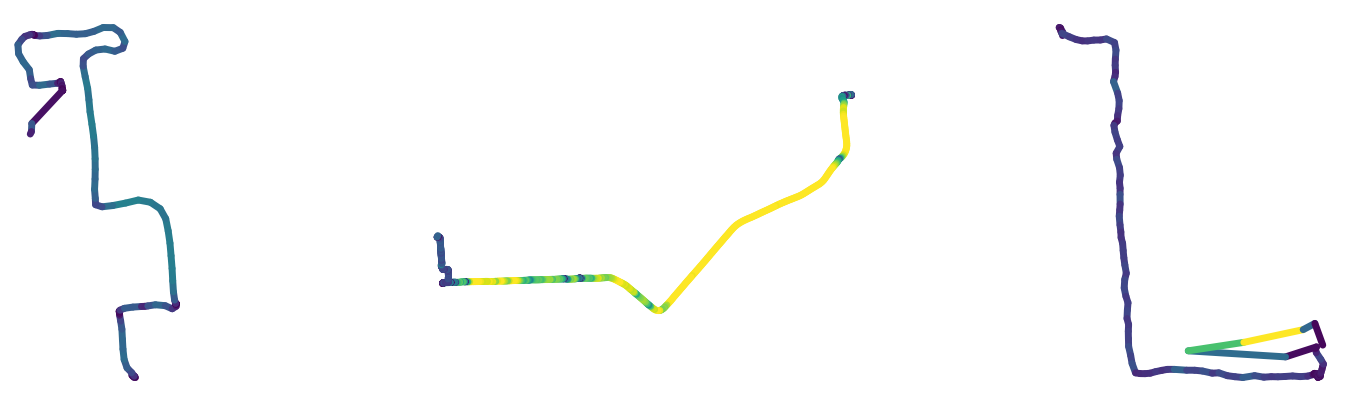

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=len(split), figsize=(20,5))
for i, traj in enumerate(split):
    traj.plot(ax=axes[i], linewidth=5.0, capstyle='round', column='speed', vmax=20)
    axes[i].set_axis_off()

**Split a trajectory where observations stay within 50 meters for at least 1 minute. Discard resulting trajectories that are shorter than 500 meters:**

In [36]:
split = mpd.StopSplitter(one_traj).split(max_diameter=30, min_duration=timedelta(minutes=1), min_length=500)
split

TrajectoryCollection with 4 trajectories

In [37]:
split.to_traj_gdf()

,traj_id,start_t,end_t,geometry,length,direction
0,2_2009-06-29 07:06:55,2009-06-29 07:06:55,2009-06-29 07:12:55,"LINESTRING (465260.626 4436071.928, 465257.097...",1862.140471,332.583018
1,2_2009-06-29 07:29:35,2009-06-29 07:29:35,2009-06-29 08:02:30,"LINESTRING (464789.957 4436663.811, 464790.812...",29760.296683,244.923082
2,2_2009-06-29 08:06:05,2009-06-29 08:06:05,2009-06-29 11:04:22,"LINESTRING (442206.019 4426276.344, 442206.024...",5046.200813,12.140478
3,2_2009-06-29 11:06:17,2009-06-29 11:06:17,2009-06-29 11:13:12,"LINESTRING (442590.394 4427970.480, 442592.157...",777.604320,1.868906


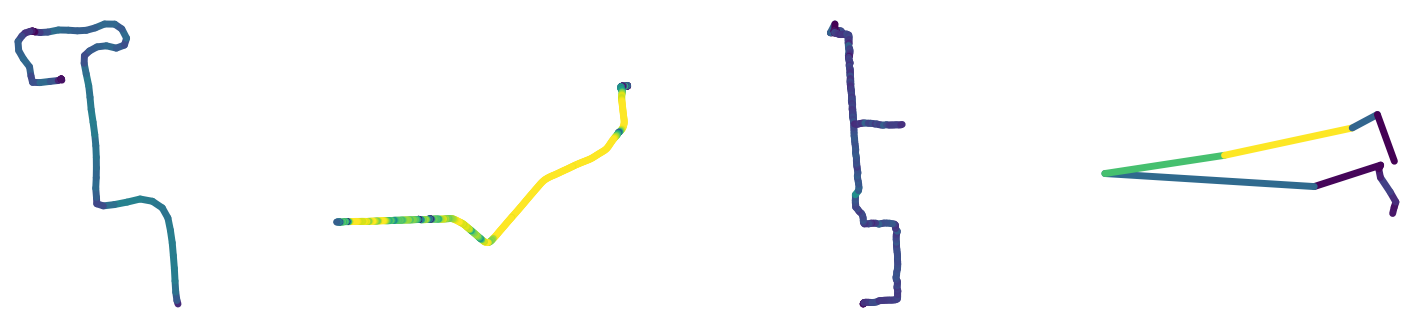

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=len(split), figsize=(19,4))
for i, traj in enumerate(split):
    traj.plot(ax=axes[i], linewidth=5.0, capstyle='round', column='speed', vmax=20)
    axes[i].set_axis_off()

**Split the trajectory where the speed is below 5 meter/second for at least five minutes:**

In [39]:
split = mpd.SpeedSplitter(one_traj).split(speed=5, duration=timedelta(minutes=5))
split

TrajectoryCollection with 4 trajectories

In [40]:
split.to_traj_gdf()

,traj_id,start_t,end_t,geometry,length,direction
0,2_0,2009-06-29 07:03:30,2009-06-29 07:17:00,"LINESTRING (465088.031 4435884.473, 465084.184...",2316.303121,337.871476
1,2_1,2009-06-29 07:30:40,2009-06-29 08:20:15,"LINESTRING (464767.625 4436702.097, 464735.448...",33091.844371,251.128600
2,2_2,2009-06-29 10:59:02,2009-06-29 11:03:42,"LINESTRING (442074.971 4428667.458, 442119.963...",1008.409131,154.139023
3,2_3,2009-06-29 11:09:47,2009-06-29 11:10:07,"LINESTRING (442253.043 4428017.321, 442393.289...",328.405053,77.781327


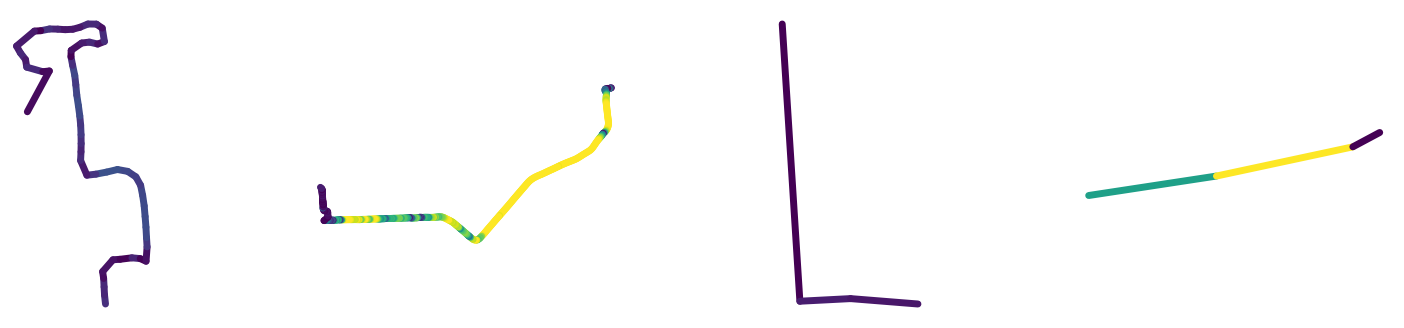

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=len(split), figsize=(19,4))
for i, traj in enumerate(split):
    traj.plot(ax=axes[i], linewidth=5.0, capstyle='round', column='speed', vmax=20)
    axes[i].set_axis_off()

#### Generalizing Trajectories

In geospatial data science, you often use different generalisation/simplification methods to reduce the file size.
For trajectory data, this means reducing the number of points used to describe the trajectory.

Available methods for doing this is for example:
- Spatial generalisation, such as Douglas-Peucker algorithm (often used to simplify spatial geometries)
- Temporal generalisation by down-sampling, i.e. increasing the time interval between records
- Spatiotemporal generalisation, e.g. using Top-Down Time Ratio algorithm

Below we will try performing a spatial generalisation. You can see examples of the other methods [here](https://github.com/anitagraser/movingpandas-examples/blob/main/1-tutorials/7-generalizing-trajectories.ipynb).

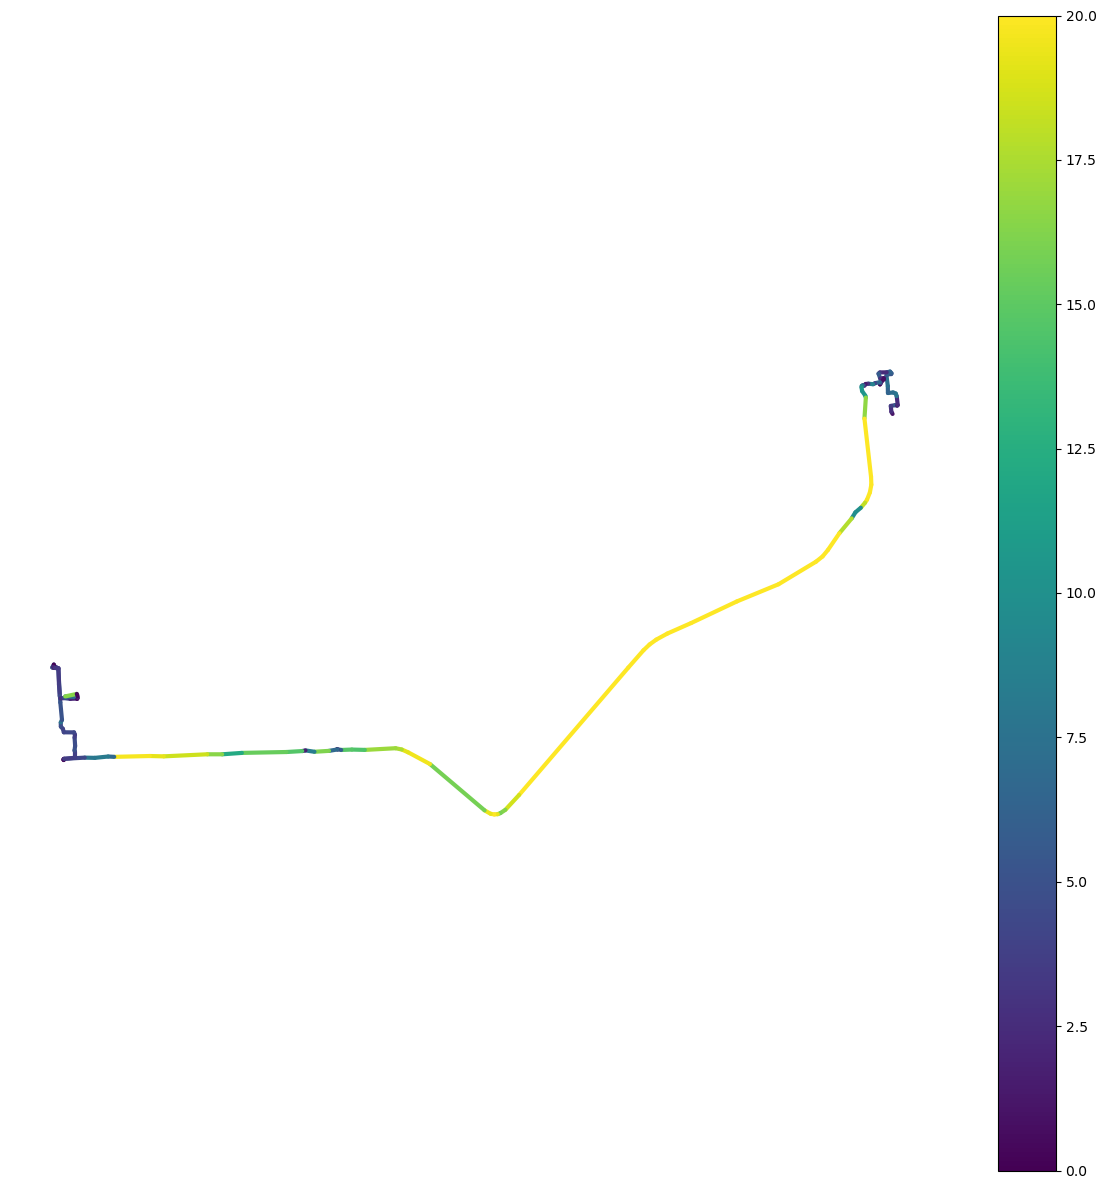

In [42]:
fig, ax = plt.subplots(figsize=(15,15))
dp_generalized  = mpd.DouglasPeuckerGeneralizer(one_traj).generalize(tolerance=10)
dp_generalized.plot(ax=ax, column='speed', vmax=20, **plot_defaults)

ax.set_axis_off()

In [43]:
print('Original length: %s'%(one_traj.get_length()))
print('Generalized length: %s'%(dp_generalized.get_length()))

Original length: 38750.11232207025
Generalized length: 38504.01959478163


#### Aggregating Trajectories

MovingPandas allows for aggregating trajectories between the same areas.

You can read about the exact spatial aggregation method [here](https://github.com/anitagraser/movingpandas-examples/blob/main/1-tutorials/9-aggregating-trajectories.ipynb).

In [44]:
# If we first generalise the trajectories, the aggregating is much faster
generalized = mpd.MinDistanceGeneralizer(traj_collection).generalize(tolerance=100)

aggregator = mpd.TrajectoryCollectionAggregator(generalized, max_distance=1000, min_distance=100, min_stop_duration=timedelta(minutes=5))

# Get gdfs with all points, clusters and flows
pts = aggregator.get_significant_points_gdf()
clusters = aggregator.get_clusters_gdf()
flows = aggregator.get_flows_gdf()

In [45]:
# Max marker size 
max_size = 150

# Create column with marker size of each cluster
clusters['n_norm'] = (clusters.n - clusters.n.min()) / (clusters.n.max() - clusters.n.min())
clusters['m_size'] = clusters.n_norm * max_size

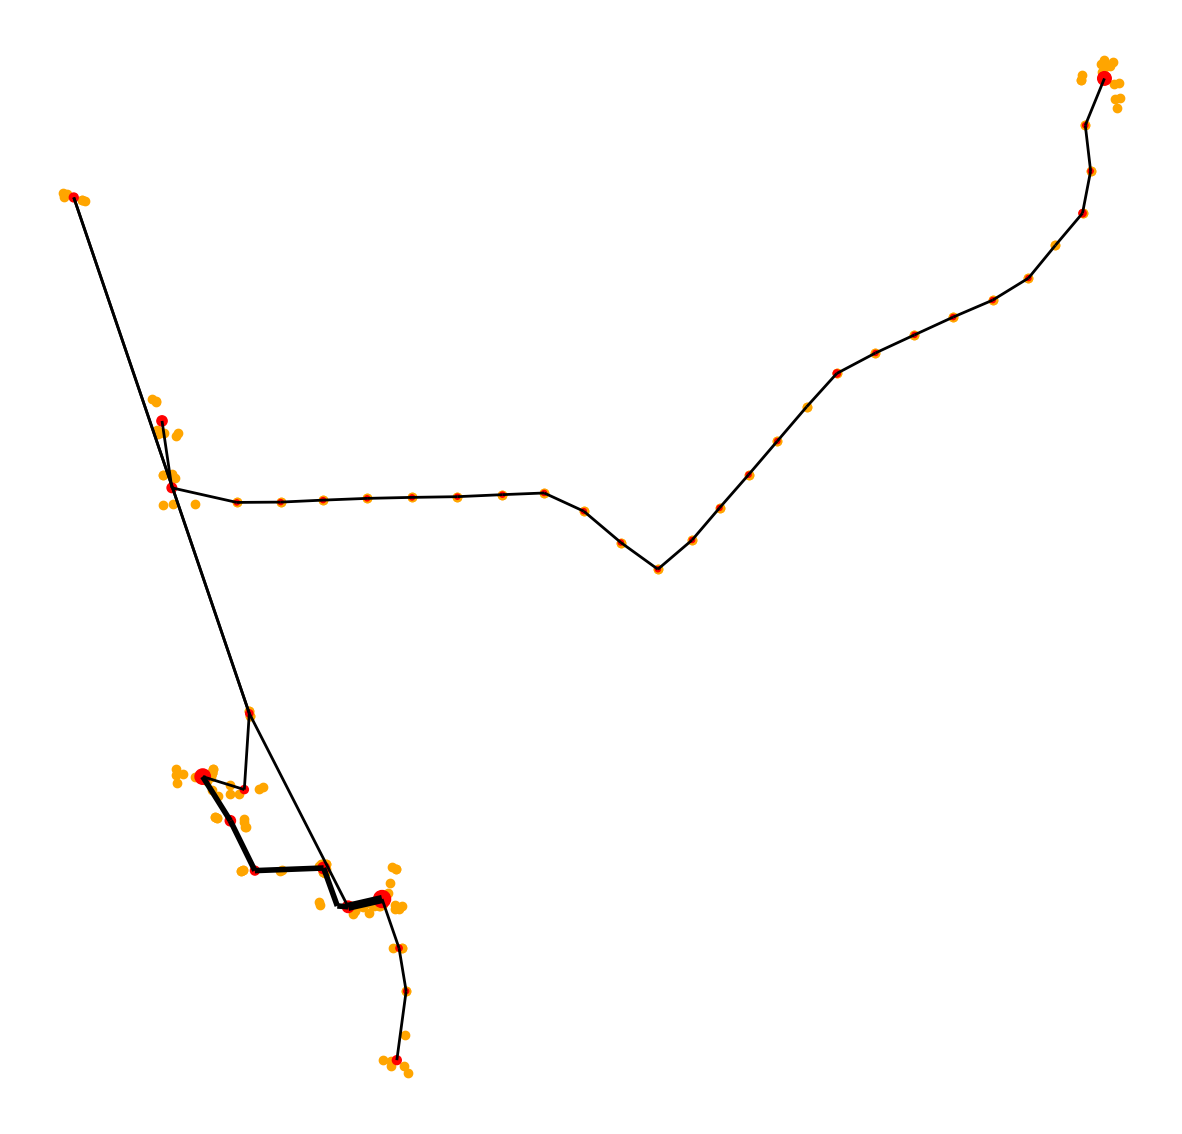

In [46]:
fig, ax = plt.subplots(figsize=(15,15))

flows.plot(ax=ax, linewidth=flows.weight*2, color='black')
pts.plot(ax=ax, color='orange')
clusters.plot(ax=ax, color='red', markersize=clusters['m_size'])

ax.set_axis_off()

In [47]:
clusters.head(5)

,geometry,n,n_norm,m_size
0,POINT (447494.167 4416841.527),22,1.000000,150.000000
1,POINT (447848.173 4412975.575),6,0.272727,40.909091
2,POINT (447901.496 4415662.932),3,0.136364,20.454545
3,POINT (448071.814 4414631.079),2,0.090909,13.636364
4,POINT (464827.957 4436532.082),14,0.636364,95.454545


#### Stop Detection

In GPS data, an object is rarely completely still due to measurement inaccuracies. You therefore need to define what count as a stop for your specific analysis.

In the MovingPandas method for detecting stops, TrajectoryStopDetector, a stop is where a movement stays within an specified area size for a specified time duration.

In [48]:
stop_detector = mpd.TrajectoryStopDetector(one_traj)
stop_time_ranges = stop_detector.get_stop_time_ranges(min_duration=timedelta(seconds=60), max_diameter=100)

for s in stop_time_ranges: 
    print(s)

Traj 2: 2009-06-29 07:02:25 - 2009-06-29 07:03:30 (duration: 0 days 00:01:05)
Traj 2: 2009-06-29 07:03:40 - 2009-06-29 07:04:40 (duration: 0 days 00:01:00)
Traj 2: 2009-06-29 07:05:05 - 2009-06-29 07:07:00 (duration: 0 days 00:01:55)
Traj 2: 2009-06-29 07:10:30 - 2009-06-29 07:11:30 (duration: 0 days 00:01:00)
Traj 2: 2009-06-29 07:12:15 - 2009-06-29 07:13:55 (duration: 0 days 00:01:40)
Traj 2: 2009-06-29 07:17:00 - 2009-06-29 07:30:45 (duration: 0 days 00:13:45)
Traj 2: 2009-06-29 07:31:40 - 2009-06-29 07:33:05 (duration: 0 days 00:01:25)
Traj 2: 2009-06-29 08:02:25 - 2009-06-29 08:03:45 (duration: 0 days 00:01:20)
Traj 2: 2009-06-29 08:04:20 - 2009-06-29 08:05:25 (duration: 0 days 00:01:05)
Traj 2: 2009-06-29 08:05:35 - 2009-06-29 08:07:20 (duration: 0 days 00:01:45)
Traj 2: 2009-06-29 08:18:25 - 2009-06-29 08:19:40 (duration: 0 days 00:01:15)
Traj 2: 2009-06-29 11:04:07 - 2009-06-29 11:06:37 (duration: 0 days 00:02:30)
Traj 2: 2009-06-29 11:06:47 - 2009-06-29 11:09:12 (duration: 0 d

In [49]:
stop_points = stop_detector.get_stop_points(min_duration=timedelta(seconds=60), max_diameter=100)
stop_points

,geometry,start_time,end_time,traj_id,duration_s
stop_id,,,,,
2_2009-06-29 07:02:25,POINT (465121.193 4435828.265),2009-06-29 07:02:25,2009-06-29 07:03:30,2,65.0
2_2009-06-29 07:03:40,POINT (465072.290 4436041.381),2009-06-29 07:03:40,2009-06-29 07:04:40,2,60.0
2_2009-06-29 07:05:05,POINT (465260.754 4436071.363),2009-06-29 07:05:05,2009-06-29 07:07:00,2,115.0
2_2009-06-29 07:10:30,POINT (464782.393 4436972.190),2009-06-29 07:10:30,2009-06-29 07:11:30,2,60.0
2_2009-06-29 07:12:15,POINT (464879.949 4436798.250),2009-06-29 07:12:15,2009-06-29 07:13:55,2,100.0
2_2009-06-29 07:17:00,POINT (464790.784 4436662.975),2009-06-29 07:17:00,2009-06-29 07:30:45,2,825.0
2_2009-06-29 07:31:40,POINT (464346.845 4436627.421),2009-06-29 07:31:40,2009-06-29 07:33:05,2,85.0
2_2009-06-29 08:02:25,POINT (442650.274 4426310.063),2009-06-29 08:02:25,2009-06-29 08:03:45,2,80.0
2_2009-06-29 08:04:20,POINT (442209.819 4426262.774),2009-06-29 08:04:20,2009-06-29 08:05:25,2,65.0


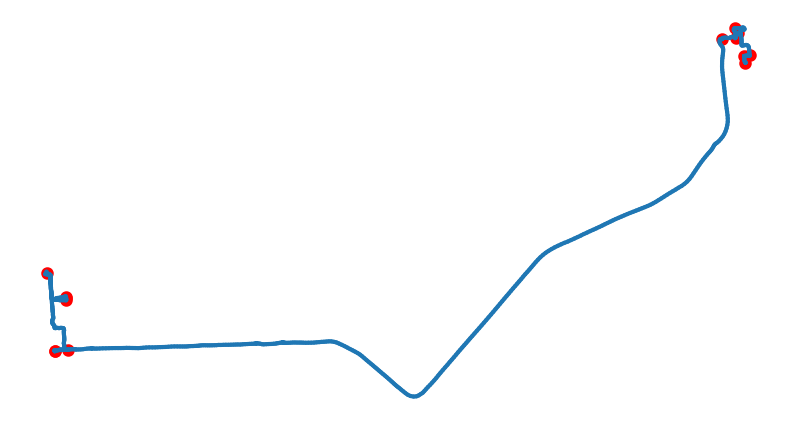

In [50]:
fig, ax = plt.subplots(figsize=(10,10))

one_traj.plot(ax=ax, **plot_defaults)
stop_points.plot(ax=ax, color='red', **plot_defaults)

ax.set_axis_off()

#### Exporting Trajectories

Trajectory collections and inidividual trajectories can be converted back to a GeoDataFrame (and from here to other formats).
Depending on how you want the data, it can be converted to either point, line or trajectory format.

In [51]:
point_gdf = traj_collection.to_point_gdf()

line_gdf = traj_collection.to_line_gdf()

traj_gdf = traj_collection.to_traj_gdf()

In [52]:
point_gdf.head(5)

,id,sequence,trajectory_id,tracker,geometry
t,,,,,
2008-12-11 04:42:14,1,1,1,19,POINT (447965.009 4416677.210)
2008-12-11 04:42:16,2,2,1,19,POINT (447966.068 4416682.086)
2008-12-11 04:43:26,3,3,1,19,POINT (447932.811 4416681.869)
2008-12-11 04:43:32,4,4,1,19,POINT (447924.707 4416684.366)
2008-12-11 04:43:47,5,5,1,19,POINT (447803.126 4416694.964)


In [53]:
line_gdf.head(5)

,id,sequence,trajectory_id,tracker,t,prev_t,geometry
0,2,2,1,19,2008-12-11 04:42:16,2008-12-11 04:42:14,"LINESTRING (447965.009 4416677.210, 447966.068..."
1,3,3,1,19,2008-12-11 04:43:26,2008-12-11 04:42:16,"LINESTRING (447966.068 4416682.086, 447932.811..."
2,4,4,1,19,2008-12-11 04:43:32,2008-12-11 04:43:26,"LINESTRING (447932.811 4416681.869, 447924.707..."
3,5,5,1,19,2008-12-11 04:43:47,2008-12-11 04:43:32,"LINESTRING (447924.707 4416684.366, 447803.126..."
4,6,6,1,19,2008-12-11 04:43:50,2008-12-11 04:43:47,"LINESTRING (447803.126 4416694.964, 447897.585..."


In [54]:
traj_gdf.head(5) # Direction column is in degrees

,traj_id,start_t,end_t,geometry,length,direction
0,1,2008-12-11 04:42:14,2008-12-11 05:15:46,"LINESTRING (447965.009 4416677.210, 447966.068...",6204.744775,187.097952
1,2,2009-06-29 07:02:25,2009-06-29 11:13:12,"LINESTRING (465120.841 4435824.386, 465116.430...",38750.112322,250.919361
2,3,2009-02-04 04:32:53,2009-02-04 11:20:12,"LINESTRING (447485.832 4416813.684, 447482.747...",12740.529638,304.404146
3,4,2009-03-10 10:36:45,2009-03-10 12:01:07,"LINESTRING (447690.691 4417216.853, 447689.813...",14358.570750,301.026049
4,5,2009-02-25 09:47:03,2009-02-25 14:31:24,"LINESTRING (447449.196 4416869.100, 447448.647...",39245.644860,305.488247


### More Advanced Analysis

You've now seen examples of how we can use MovingPandas to manipulate and visualize trajectory data.
For examples of more advanced analysis see the notebooks [here](https://github.com/anitagraser/movingpandas-examples/tree/main/2-analysis-examples) :)